In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sampyl as smp
from statsmodels.nonparametric.kernel_density import KDEMultivariate
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter

/Users/marcbeillevaire/anaconda/envs/datapred/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
train = pd.read_csv('./datasets/titanic_train.csv')
test  = pd.read_csv('./datasets/titanic_test.csv')

## Data preparation

In [3]:
data = pd.concat([train, test])

data['Age'] = data['Age'].fillna(data['Age'].median())
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

data.Sex, mapper_sex      = pd.factorize(data.Sex)
data.Embarked, mapper_emb = pd.factorize(data.Embarked)
data.Pclass = 1 - (data.Pclass == 3).astype(int)

to_drop = ['PassengerId', 'Ticket', 'Cabin', 'Name', 'Embarked']# 'Embarked', 'Pclass', 'Parch', 'Sex', 'SibSp']
data.drop(to_drop, axis=1, inplace=True)

maxs = data.drop("Survived", axis=1).max()

data.head()

,Age,Fare,Parch,Pclass,Sex,SibSp,Survived
0,22.0,7.2500,0,0,0,1,0.0
1,38.0,71.2833,0,1,1,1,1.0
2,26.0,7.9250,0,0,1,0,1.0
3,35.0,53.1000,0,1,1,1,1.0
4,35.0,8.0500,0,0,0,0,0.0


In [4]:
train = data[~pd.isnull(data.Survived)].fillna(0.0)
test = train.iloc[int(train.shape[0] * 0.8):]
train = train.iloc[:int(train.shape[0] * 0.8)]
#test  = data.loc[pd.isnull(data.Survived)].fillna(0.0)

### The good model

In [89]:
train_x = train.drop('Survived', axis=1)
train_y = train.Survived
test_x = test.drop("Survived", axis=1)
test_y = test.Survived

rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=-1, min_samples_leaf=4)
rf.fit(train_x, train_y)

preds = rf.predict_proba(test_x)[:,1]

### The noisy model

In [90]:
# Change some of the targets (20%)
pts_ids = np.random.randint(train.shape[0], size=(int(train.shape[0] * 0.5)))
noisy_train_y = train_y.copy()
for i in pts_ids:
    noisy_train_y.iloc[i] = 1 - noisy_train_y.iloc[i]

In [91]:
noisy_rf = RandomForestClassifier(n_estimators=250)
noisy_rf.fit(train_x, noisy_train_y)

noisy_preds = noisy_rf.predict_proba(test_x)[:,1]

0.913451086957
0.712975543478


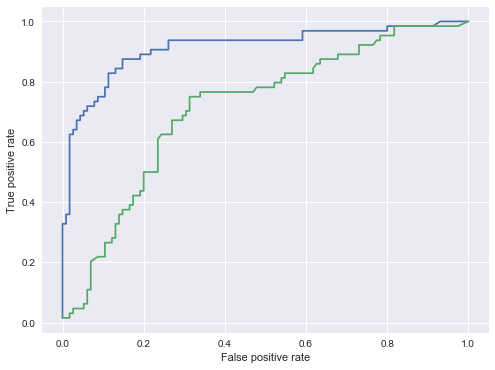

In [92]:
from sklearn.metrics import roc_curve, roc_auc_score

print(roc_auc_score(test_y.astype(int), preds))
print(roc_auc_score(test_y.astype(int), noisy_preds))

fpr_t, tpr_t, thres_t = roc_curve(test_y, preds)
fpr_v, tpr_v, thres_v = roc_curve(test_y, noisy_preds)

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(8,6))
plt.plot(fpr_t, tpr_t, '-')
plt.plot(fpr_v, tpr_v, '-')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

### Pick random points in the dataset

In [23]:
pts_ids = np.random.randint(test.shape[0], size=(1))
X = test_x.iloc[pts_ids[0]]

idx = pts_ids[0]

print(X)
print("Truth: {0}.".format(test_y.iloc[idx]))
print(rf.predict_proba([X]))
print(noisy_rf.predict_proba([X]))

Age       22.0000
Fare      10.5167
Parch      0.0000
Pclass     0.0000
Sex        1.0000
SibSp      0.0000
Name: 882, dtype: float64
Truth: 0.0.
[[ 0.55  0.45]]
[[ 0.168  0.832]]


### Explain

In [25]:
pred, bias, contrib = treeinterpreter.predict(rf, X)
contrib = pd.DataFrame(contrib[:,:,1], columns=test_x.columns)
c = contrib.iloc[0]

srtd = c.sort_values()
sns.barplot(srtd.values, srtd.index)

/Users/marcbeillevaire/Google Drive/repos/scikit-learn-0.18_kpp/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


IndexError: tuple index out of range

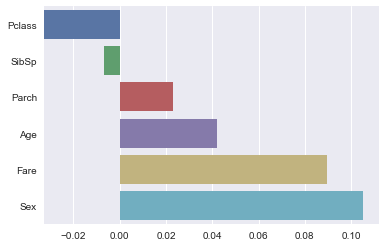

In [131]:
pred_0, bias_0, contrib_0 = treeinterpreter.predict(noisy_rf, points)
contrib_0 = pd.DataFrame(contrib_0[:,:,1], columns=test_x.columns)

c = contrib_0.iloc[0]

srtd = c.sort_values()
sns.barplot(srtd.values, srtd.index)

In [148]:
from lime.lime_tabular import LimeTabularExplainer

features = train_x.columns.tolist()
def predict_fn(x):
    return rf.predict_proba(x)

def predict_fn_noisy(x):
    return noisy_rf.predict_proba(x)

explainer = LimeTabularExplainer(train_x.values, feature_names=features, kernel_width=3)
explainer2 = LimeTabularExplainer(train_x.values, feature_names=features, kernel_width=3,
                                  training_labels=train_y.values, discretizer='entropy')

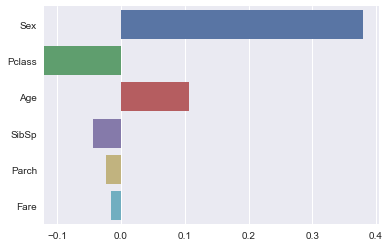

In [151]:
exp = explainer.explain_instance(X.values, predict_fn, num_features=6)
m = list(zip(*exp.as_map()[1]))
f = [features[i] for i in m[0]]
sns.barplot(m[1], f)

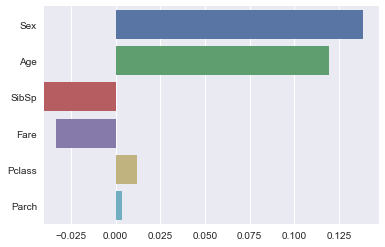

In [152]:
exp = explainer.explain_instance(X.values, predict_fn_noisy, num_features=6)
m = list(zip(*exp.as_map()[1]))
f = [features[i] for i in m[0]]
sns.barplot(m[1], f)

Progress: [##############################] 3000 of 3000 samples


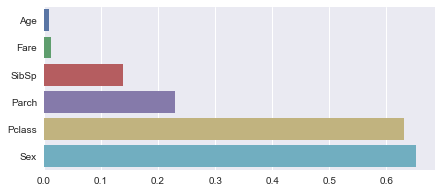

In [127]:
explainer = ParzenExplainer(rf, train_x, X, 3000)
explainer.explain()

Progress: [##############################] 3000 of 3000 samples


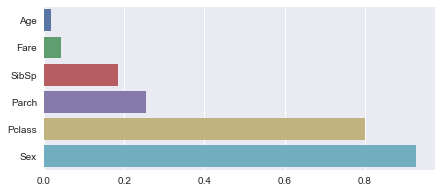

In [128]:
explainer = ParzenExplainer(noisy_rf, train_x, X, 3000)
explainer.explain()

In [106]:
class ParzenExplainer:
    
    def __init__(self, model, train_x, X, N_obs):
        self.model = model
        self.X = X
        self.features = X.index
        self.maxs = train_x.max()
        self.mins = train_x.min()
        self.n_dim = X.shape[0]
        self.N_obs = N_obs

    def pdf_deriv(self, x, samples, bw):
        coef =  1 / (self.N_obs * (np.sqrt(2 * np.pi)**self.n_dim))
        mtrx = [-0.5 * sum((x - x_i) * (x - x_i) / (bw * bw)) for x_i in samples]
        deriv_vector = -np.array([(x - x_i) / (bw * bw) for x_i in samples])

        return (coef * np.sum(np.exp(mtrx)) / np.prod(bw)) * np.sum(deriv_vector, axis=0)

    def contribution(self, X, samples, bw):
        contribs = pd.Series(self.pdf_deriv(X, samples, bw), index=self.features).sort_values()
        return contribs

    def explain(self):
        
        def logp(Age, Fare, Parch, Pclass, Sex, SibSp):
            vector = np.array([
                np.floor(Age).astype(int),
                np.floor(Fare).astype(int),
                np.floor(Parch).astype(int),
                np.floor(Pclass).astype(int),
                np.floor(Sex).astype(int),
                np.floor(SibSp).astype(int),                
            ])

            if (vector > self.maxs).any() or (vector < 0).any():
                return -np.infty

            ret = np.log(1 - self.model.predict_proba([vector])[0,1])
            return ret

        # Start Parzen
        start = self.X.to_dict()
        metro_hast = smp.Metropolis(logp, start)
        chain = metro_hast.sample(self.N_obs)

        smpld = chain.view((np.float, self.n_dim))

        density = KDEMultivariate(data=smpld, var_type='c' * self.n_dim, bw='normal_reference')
        bw = density.bw

        # Compute contributions
        ctrb = self.contribution(X, smpld, bw)

        # Plot
        fig = sns.plt.figure(figsize=(7, 3))
        sns.barplot(ctrb.values, ctrb.index)
        fig.savefig('../report/img/1-2-1.svg')

## Mode features influence

In [ ]:
test.median()

In [ ]:
pred, bias, contrib = treeinterpreter.predict(rf, test.mode())
contrib = pd.DataFrame(contrib[:,:,1], columns=test.columns)

In [ ]:
fig = plt.figure(figsize=(7, 3))

c = contrib.loc[0]
srtd = c.sort_values()
sns.barplot(srtd.values, srtd.index)

fig.savefig('../report/img/titanic-treeint-mode.svg')